# Xception heatmap

This experiment will explore heatmaps of various images through an Xception model.

## Setup

In [13]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import re
import pandas as pd
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [3]:
def load_and_preprocess_image(image_path):
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.xception.preprocess_input(img_array)
    return img_array

def generate_gradcam_heatmap(model, layer_name, image_array, class_index):
    conv_layer = model.get_layer(layer_name)
    
    # Create a model that maps the input image to the last convolutional layer output and predictions
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[conv_layer.output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image_array)
        loss = predictions[:, class_index]
    # Compute gradients of the class output with respect to the convolutional layer outputs
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_outputs = conv_outputs[0].numpy()  # Convert tensor to numpy array
    pooled_grads = pooled_grads.numpy()     # Convert tensor to numpy array
    
    # Weight the feature maps by the pooled gradients
    conv_outputs *= pooled_grads
    heatmap = np.mean(conv_outputs, axis=-1)
    
    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap = cv2.resize(heatmap, (128, 128))
    if np.max(heatmap) == np.min(heatmap):
        heatmap = np.zeros_like(heatmap)
    else:
        heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
    
    return heatmap

def overlay_heatmap(image_path, heatmap):
    # Load original image
    original_img = cv2.imread(image_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    original_img = cv2.resize(original_img, (128, 128))
    
    # Create a heatmap overlay
    heatmap = np.nan_to_num(heatmap)  # Replace NaN values with 0
    heatmap = np.uint8(255 * heatmap)  # Ensure values are in the range [0, 255]
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    # Overlay the heatmap on the original image
    superimposed_img = heatmap * 0.4 + original_img
    
    # Ensure the resulting image is in the [0, 255] range and convert to uint8
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    return superimposed_img

In [14]:
cols = ["species","image", "focus_clarity", "contrast", "angle", "portion_visible", "quality"]
labels1 = pd.read_csv('pifsc_labels_detail.csv')[cols]

cols = ["species","filename","focus_clarity", "contrast", "angle", "portion_visible", "quality"]
labels2 = pd.read_csv('pifsc_labels2.csv')[cols]
labels2.columns = ["species","image","focus_clarity", "contrast", "angle", "portion_visible", "quality"]

labels = pd.concat([labels1, labels2]).reset_index(drop=True)

In [40]:
# analyze images with clarity, contrast, etc. ratings
is_na = labels.contrast.isna()
labels = labels.loc[~is_na]
labels = labels.drop_duplicates(subset='image', keep='first')
print(len(labels))

2696


In [4]:
# Load the model
model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(128,128,3))
model.summary()

2024-09-13 20:18:20.425479: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 63, 63,    │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 63, 63,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 63, 63,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 61, 61,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 61, 61,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 61, 61,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 61, 61,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 61, 61,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 61, 61,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 61, 61,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 61, 61,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 31, 31,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 31, 31,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 31, 31,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 31, 31,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 31, 31,    │          0 │ add[0][0]       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

## Load images

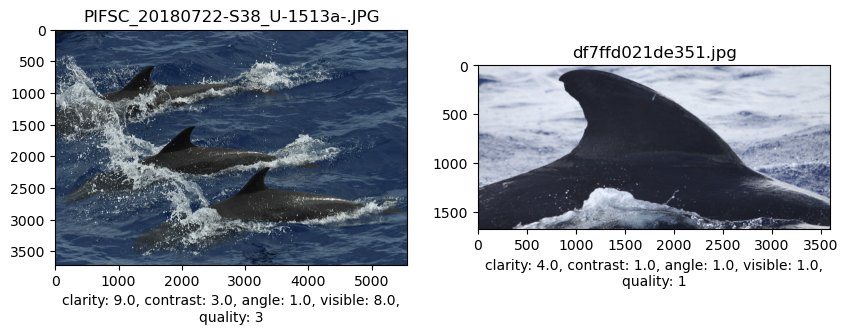

In [105]:
# Prepare the images
home = "/home/jctactay/koa_scratch/images"
img_names = labels.sample(n=2)
image_paths = []
for index, row in img_names.iterrows():
    image_paths.append(os.path.join(home, row.image))
image_arrays = []
fig, ax = plt.subplots(1,2, figsize=(10,10))
for i, image_path in enumerate(image_paths):
    text = f'clarity: {img_names.focus_clarity.iloc[i]}, contrast: {img_names.contrast.iloc[i]}, angle: {img_names.angle.iloc[i]}, visible: {img_names.portion_visible.iloc[i]},\nquality: {img_names.quality.iloc[i]}'
    image_arrays.append(load_and_preprocess_image(image_path))
    ax[i].imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    ax[i].title.set_text(img_names.image.iloc[i])
    ax[i].set_xlabel(text)

## Batch normalization layers

In [106]:
pattern = r'bn$'

In [107]:
batch_layers = [layer.name for layer in model.layers if re.search(pattern, layer.name)]
len(batch_layers)

36

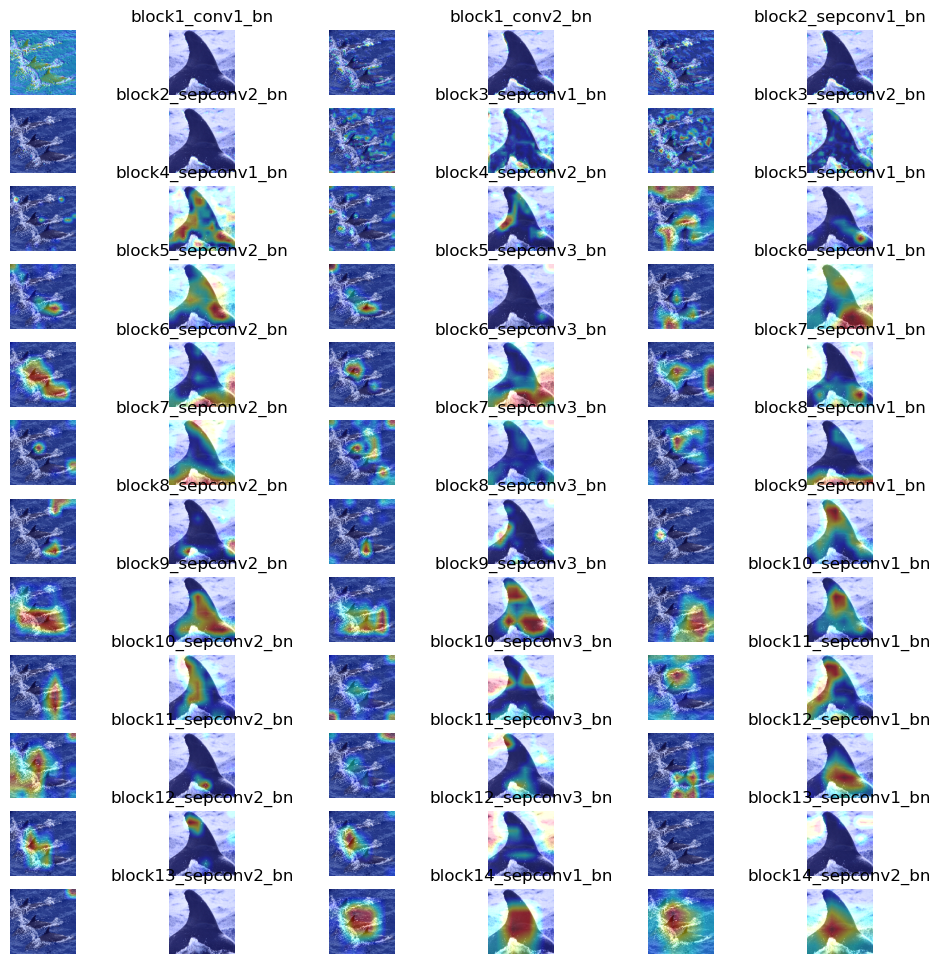

In [108]:
# Generate the heatmap
class_index = 0  # Change this to the index of the class you're interested in
n_rows = 12
n_cols = 6
fig, ax = plt.subplots(n_rows,n_cols,figsize=(12,12))
for i, layer in enumerate(batch_layers):  
    for j, image_array in enumerate(image_arrays):
        curr_plot = (i//(n_cols>>1), (2*i+j)%n_cols)
        heatmap = generate_gradcam_heatmap(model, layer, image_array, class_index)
        
        # Overlay and display the heatmap
        
        ax[*curr_plot].imshow(overlay_heatmap(image_paths[j], heatmap))
        ax[*curr_plot].title.set_text(layer if j == 1 else '')
        ax[*curr_plot].axis('off')

## Separable convolution layers with activation

In [109]:
pattern = r'act$'

In [110]:
act_layers = [layer.name for layer in model.layers if re.search(pattern, layer.name)]
len(act_layers)

35

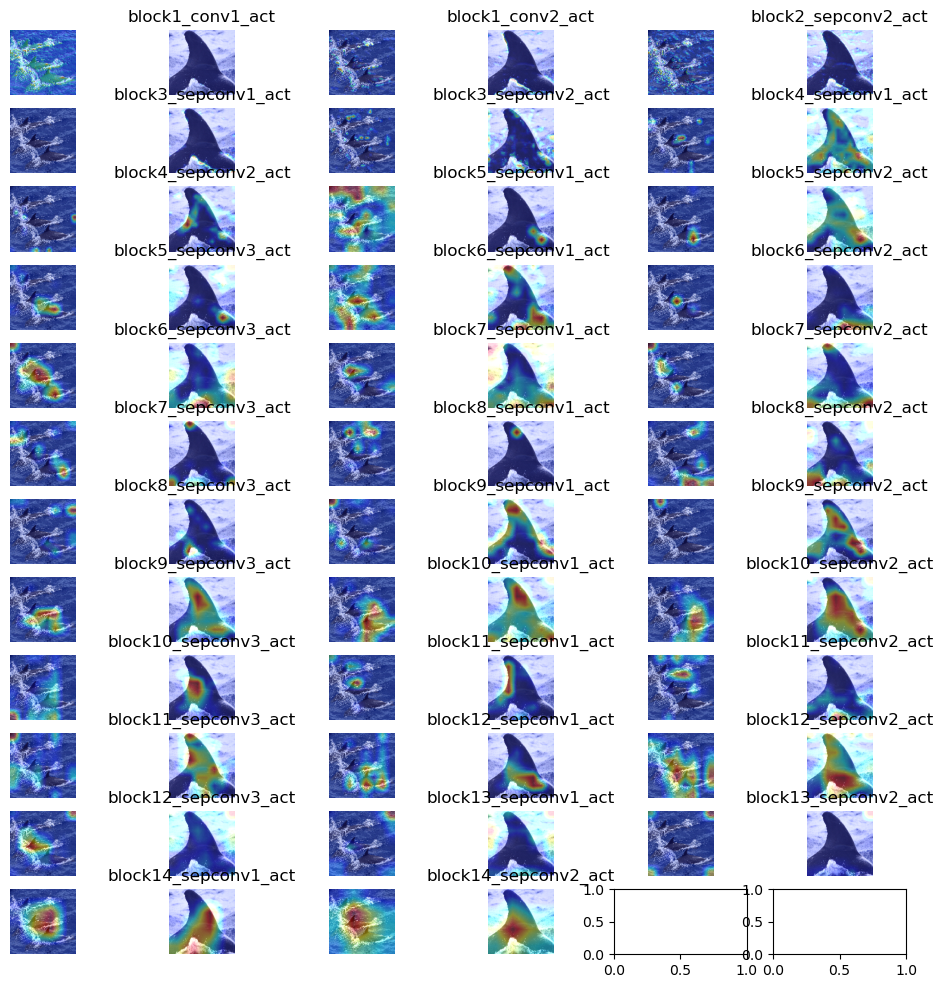

In [111]:
# Generate the heatmap
class_index = 0  # Change this to the index of the class you're interested in
n_rows = 12
n_cols = 6
fig, ax = plt.subplots(n_rows,n_cols,figsize=(12,12))
for i, layer in enumerate(act_layers):  
    for j, image_array in enumerate(image_arrays):
        curr_plot = (i//(n_cols>>1), (2*i+j)%n_cols)
        heatmap = generate_gradcam_heatmap(model, layer, image_array, class_index)
        
        # Overlay and display the heatmap
        
        ax[*curr_plot].imshow(overlay_heatmap(image_paths[j], heatmap))
        ax[*curr_plot].title.set_text(layer if j == 1 else '')
        ax[*curr_plot].axis('off')

## Block convolution layers

In [112]:
pattern = r'(conv[0-9]*)$'

In [113]:
sepconv_layers = [layer.name for layer in model.layers if re.search(pattern, layer.name)]
len(sepconv_layers)

36

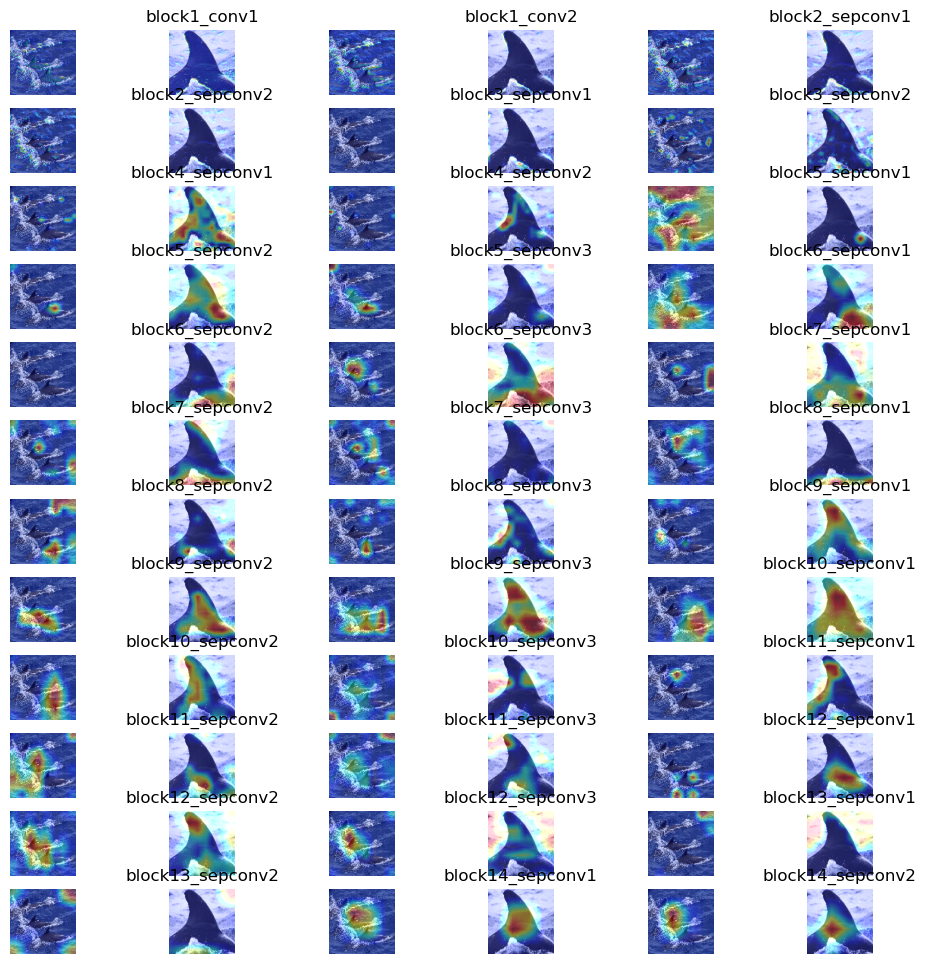

In [114]:
# Generate the heatmap
class_index = 0  # Change this to the index of the class you're interested in
n_rows = 12
n_cols = 6
fig, ax = plt.subplots(n_rows,n_cols,figsize=(12,12))
for i, layer in enumerate(sepconv_layers):  
    for j, image_array in enumerate(image_arrays):
        curr_plot = (i//(n_cols>>1), (2*i+j)%n_cols)
        heatmap = generate_gradcam_heatmap(model, layer, image_array, class_index)
        
        # Overlay and display the heatmap
        
        ax[*curr_plot].imshow(overlay_heatmap(image_paths[j], heatmap))
        ax[*curr_plot].title.set_text(layer if j == 1 else '')
        ax[*curr_plot].axis('off')

## Standard convolution layers

In [115]:
pattern = r'conv2d(_)?[0-9]*'

In [116]:
conv_layers = [layer.name for layer in model.layers if re.search(pattern, layer.name)]
len(conv_layers)

4

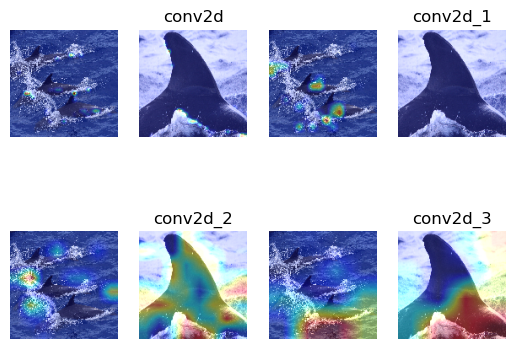

In [117]:
# Generate the heatmap
class_index = 0  # Change this to the index of the class you're interested in
n_rows = 2
n_cols = 4
fig, ax = plt.subplots(n_rows,n_cols)
for i, layer in enumerate(conv_layers):  
    for j, image_array in enumerate(image_arrays):
        curr_plot = (i//(n_cols>>1), (2*i+j)%n_cols)
        heatmap = generate_gradcam_heatmap(model, layer, image_array, class_index)
        
        # Overlay and display the heatmap
        
        ax[*curr_plot].imshow(overlay_heatmap(image_paths[j], heatmap))
        ax[*curr_plot].title.set_text(layer if j == 1 else '')
        ax[*curr_plot].axis('off')